# Semi-supervised learning
### Giacomo Filippin, Emma Lovato, Rebecca Esegio 

In [1]:

# Some useful packages
import math
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.linalg
import time
from sklearn.metrics.pairwise import euclidean_distances
import requests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_digits
# from tensorflow import keras
import pandas as pd
from io import StringIO
import os
import imageio
from os import walk
import shutil
from sklearn.datasets import make_moons, make_blobs
from sklearn.model_selection import train_test_split

## Introduction
In this project, the problem handled involves the application of semi-supervised learning on a set of randomly generated points in a 2D space, with labels assigned to a small subset. 
The problem will be solved using different optimization techniques like Gradient Descent, Block Coordinate Gradient Descent (BCGD) with Gauss-Southwell (GS) Rule, and coordinate minimization algorithms

In [2]:
# Some useful variables
NUM_ITERS = 60
NUM_POINTS = 10000
OUTPUT_STEP = 0.1
LABELED_PERCENTAGE = 0.1
OPTIMIZE_RANDOM = False
STEP_SIZE = 1e-4
EPSILON = 1e-5
USE_LIPSCHITZ_CONSTANT = True
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
INITIALIZE_RANDOM = True
PLOT_DPI=100
FROM_DATASET = False
DATASET = "mnist_keras"
CREATE_GIF = True

In [3]:
# Set the seed for reproducibility
np.random.seed(1)
random.seed(1)

# PART A

## 1. Generate points in 2D


In [4]:
%%time
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import random

def generate_semi_supervised_data(
    NUM_POINTS,
    LABELED_PERCENTAGE,
    INITIALIZE_RANDOM,
    gen1=lambda x: x,
    gen2=lambda x: -x,
    range1=(-1, 1),
    range2=(-1, 1),
    seed=None
):
    """
    Generates semi-supervised data using nomenclature from the reference notebook.

    Args:
        NUM_POINTS (int): Number of points to generate for each class.
        LABELED_PERCENTAGE (float): Percentage of points to be labeled.
        INITIALIZE_RANDOM (bool): If True, initialize unlabeled points randomly in {-1, 1}.
                                  Otherwise, initialize to 0.
        gen1 (function, optional): Function to generate y-values for the first class (class -1).
                                   Must be able to operate on NumPy arrays.
        gen2 (function, optional): Function to generate y-values for the second class (class 1).
                                   Must be able to operate on NumPy arrays.
        range1 (tuple, optional): Range for x-values for the first class.
        range2 (tuple, optional): Range for x-values for the second class.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        tuple: Contains:
            - x_labeled (np.array): Labeled data points.
            - y_labeled (np.array): Labels for x_labeled.
            - x_unlabeled (np.array): Unlabeled data points.
            - y_unlabeled_target (np.array): True labels for x_unlabeled (for evaluation).
            - y_unlabeled_initial (np.array): Initial guess for labels of x_unlabeled.
            - scaler (sklearn.pipeline.Pipeline): Scaler object used for data transformation.
            - tuples_0 (np.array): Original data points for class -1 (before splitting and scaling).
            - tupltttes_1 (np.array): Original data points for class 1 (before splitting and scaling).
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    print("Generating points")
    # Generate x values for both classes
    x0 = np.random.uniform(*range1, NUM_POINTS)
    x1 = np.random.uniform(*range2, NUM_POINTS)

    # Apply generation functions (assuming gen1 and gen2 can handle numpy arrays)
    f_x0 = gen1(x0)
    f_x1 = gen2(x1)
    print("done generating base points")

    print("Generating variances")
    # Variances as defined in the notebook (cell id: "9ec705e6")
    rand_var_0 = np.random.normal(1, 0.1, len(x0))
    rand_var_1 = np.random.normal(0, 0.1, len(x1))

    f_x0_final = f_x0 + rand_var_0
    f_x1_final = f_x1 + rand_var_1
    print("Done generating variances")
    
    tuples_0 = np.array(list(zip(x0, f_x0_final)))
    tuples_1 = np.array(list(zip(x1, f_x1_final)))
    
    print("Splitting points in labeled and unlabeled")
    print(f"{len(tuples_0)} elements class -1 and {len(tuples_1)} elements class 1 (raw)")

    if len(tuples_0) == 0 or len(tuples_1) == 0:
        raise ValueError("One or both classes have zero samples. Check NUM_POINTS.")

    # Scaler setup (matches notebook cell id: "5c73ecba")
    scaler = Pipeline([('mm_scaler', MinMaxScaler()),('std_scaler', StandardScaler())])
    all_tuples = np.concatenate((tuples_0, tuples_1))
    if all_tuples.shape[0] == 0:
        raise ValueError("No data to fit scaler. tuples_0 and tuples_1 are empty.")
    scaler.fit(all_tuples)

    # Splitting and labeling (matches notebook cell id: "5c73ecba")
    # Class -1 (from tuples_0)
    slice_index_0 = int(len(tuples_0) * LABELED_PERCENTAGE)
    x_0_unlabeled_orig = tuples_0[slice_index_0:]
    x_bar_0_orig = tuples_0[:slice_index_0]

    # Class 1 (from tuples_1)
    slice_index_1 = int(len(tuples_1) * LABELED_PERCENTAGE)
    x_1_unlabeled_orig = tuples_1[slice_index_1:]
    x_bar_1_orig = tuples_1[:slice_index_1]
    
    # Scale the data
    x_0 = scaler.transform(x_0_unlabeled_orig) if len(x_0_unlabeled_orig) > 0 else np.array([])
    x_bar_0 = scaler.transform(x_bar_0_orig) if len(x_bar_0_orig) > 0 else np.array([])
    
    x_1 = scaler.transform(x_1_unlabeled_orig) if len(x_1_unlabeled_orig) > 0 else np.array([])
    x_bar_1 = scaler.transform(x_bar_1_orig) if len(x_bar_1_orig) > 0 else np.array([])

    # Create labels
    y_0 = np.repeat(-1, len(x_0)).astype('float64')
    y_bar_0 = np.repeat(-1, len(x_bar_0)).astype('float64')
    y_1 = np.repeat(1, len(x_1)).astype('float64')
    y_bar_1 = np.repeat(1, len(x_bar_1)).astype('float64')

    # Concatenate labeled and unlabeled sets
    x_unlabeled_list = []
    if len(x_0) > 0: x_unlabeled_list.append(x_0)
    if len(x_1) > 0: x_unlabeled_list.append(x_1)
    x_unlabeled = np.concatenate(x_unlabeled_list) if x_unlabeled_list else np.array([])
    
    x_labeled_list = []
    if len(x_bar_0) > 0: x_labeled_list.append(x_bar_0)
    if len(x_bar_1) > 0: x_labeled_list.append(x_bar_1)
    x_labeled = np.concatenate(x_labeled_list) if x_labeled_list else np.array([])

    y_labeled_list = []
    if len(y_bar_0) > 0: y_labeled_list.append(y_bar_0)
    if len(y_bar_1) > 0: y_labeled_list.append(y_bar_1)
    y_labeled = np.concatenate(y_labeled_list) if y_labeled_list else np.array([])

    y_unlabeled_target_list = []
    if len(y_0) > 0: y_unlabeled_target_list.append(y_0)
    if len(y_1) > 0: y_unlabeled_target_list.append(y_1)
    y_unlabeled_target = np.concatenate(y_unlabeled_target_list) if y_unlabeled_target_list else np.array([])

    # Initialize y_unlabeled_initial (matches notebook cell id: "5c73ecba")
    if len(x_unlabeled) > 0:
        if INITIALIZE_RANDOM:
            y_unlabeled_initial = np.random.choice([-1.0, 1.0], size=(len(x_unlabeled),)).astype('float64')
        else:
            # Matches: np.array([0], dtype='float64').repeat(len(x_unlabeled))
            y_unlabeled_initial = np.repeat(np.array([0], dtype='float64'), len(x_unlabeled))
    else:
        y_unlabeled_initial = np.array([])
    
    print(f"{len(x_labeled)} elements labeled and {len(x_unlabeled)} elements unlabeled")
    print("Done splitting and scaling.")

    return x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial, scaler, tuples_0, tuples_1

if __name__ == '__main__':
    # Default synthetic data functions and ranges from the notebook (cell id="b7d62a1a")
    active_gen1 = lambda x_val: x_val
    active_gen2 = lambda x_val: -x_val
    active_range1 = (-1, 1)
    active_range2 = (-1, 1)

    print("--- Generating Synthetic Data (Notebook Nomenclature) ---")
    # Parameters from notebook (cell id="12bac363")
    # NUM_POINTS = 10000 (example, can be changed)
    # LABELED_PERCENTAGE = 0.1
    # INITIALIZE_RANDOM = True
    
    x_l, y_l, x_ul, y_ul_target, y_ul_init, scl, t0_orig, t1_orig = generate_semi_supervised_data(
        NUM_POINTS=1000, # Example value
        LABELED_PERCENTAGE=0.1,
        INITIALIZE_RANDOM=True,
        gen1=active_gen1,
        gen2=active_gen2,
        range1=active_range1,
        range2=active_range2,
        seed=1 # Matches notebook seed
    )
    print(f"x_labeled shape: {x_l.shape}, y_labeled shape: {y_l.shape}")
    print(f"x_unlabeled shape: {x_ul.shape}, y_unlabeled_target shape: {y_ul_target.shape}")
    print(f"y_unlabeled_initial mean (if random): {y_ul_init.mean() if len(y_ul_init) > 0 else 'N/A'}")
    print(f"Original tuples_0 shape: {t0_orig.shape}")
    print(f"Original tuples_1 shape: {t1_orig.shape}")

    print("\n--- Test with INITIALIZE_RANDOM = False ---")
    x_l_nr, y_l_nr, x_ul_nr, y_ul_target_nr, y_ul_init_nr, _, _, _ = generate_semi_supervised_data(
        NUM_POINTS=50,
        LABELED_PERCENTAGE=0.5,
        INITIALIZE_RANDOM=False, # Test this case
        seed=42
    )
    print(f"y_unlabeled_initial_nr (should be all zeros): {y_ul_init_nr}")
    if len(y_ul_init_nr) > 0:
        print(f"y_unlabeled_initial_nr all zeros: {np.all(y_ul_init_nr == 0)}")


--- Generating Synthetic Data (Notebook Nomenclature) ---
Generating points
done generating base points
Generating variances
Done generating variances
Splitting points in labeled and unlabeled
1000 elements class -1 and 1000 elements class 1 (raw)
200 elements labeled and 1800 elements unlabeled
Done splitting and scaling.
x_labeled shape: (200, 2), y_labeled shape: (200,)
x_unlabeled shape: (1800, 2), y_unlabeled_target shape: (1800,)
y_unlabeled_initial mean (if random): 0.044444444444444446
Original tuples_0 shape: (1000, 2)
Original tuples_1 shape: (1000, 2)

--- Test with INITIALIZE_RANDOM = False ---
Generating points
done generating base points
Generating variances
Done generating variances
Splitting points in labeled and unlabeled
50 elements class -1 and 50 elements class 1 (raw)
50 elements labeled and 50 elements unlabeled
Done splitting and scaling.
y_unlabeled_initial_nr (should be all zeros): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

In [5]:
%%time
gen1_func = lambda x_val: x_val
gen2_func = lambda x_val: -x_val
range1_val = (-1, 1)
range2_val = (-1, 1)
current_seed = 1
# Call the function to generate data 
print("--- Generating Main Synthetic Data for the Notebook ---")
x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial, scaler, tuples_0_original, tuples_1_original = generate_semi_supervised_data(
    NUM_POINTS=NUM_POINTS,
    LABELED_PERCENTAGE=LABELED_PERCENTAGE,
    INITIALIZE_RANDOM=INITIALIZE_RANDOM,
    gen1=gen1_func,
    gen2=gen2_func,
    range1=range1_val,
    range2=range2_val,
    seed=current_seed
)

# Print shapes to confirm the data generation
print(f"x_labeled shape: {x_labeled.shape if x_labeled is not None else 'None'}")
print(f"y_labeled shape: {y_labeled.shape if y_labeled is not None else 'None'}")
print(f"x_unlabeled shape: {x_unlabeled.shape if x_unlabeled is not None else 'None'}")
print(f"y_unlabeled_target shape: {y_unlabeled_target.shape if y_unlabeled_target is not None else 'None'}")
print(f"y_unlabeled_initial shape: {y_unlabeled_initial.shape if y_unlabeled_initial is not None else 'None'}")
print(f"tuples_0_original shape: {tuples_0_original.shape if tuples_0_original is not None else 'None'}")
print(f"tuples_1_original shape: {tuples_1_original.shape if tuples_1_original is not None else 'None'}")


--- Generating Main Synthetic Data for the Notebook ---
Generating points
done generating base points
Generating variances
Done generating variances
Splitting points in labeled and unlabeled
10000 elements class -1 and 10000 elements class 1 (raw)
2000 elements labeled and 18000 elements unlabeled
Done splitting and scaling.
x_labeled shape: (2000, 2)
y_labeled shape: (2000,)
x_unlabeled shape: (18000, 2)
y_unlabeled_target shape: (18000,)
y_unlabeled_initial shape: (18000,)
tuples_0_original shape: (10000, 2)
tuples_1_original shape: (10000, 2)
CPU times: total: 31.2 ms
Wall time: 50.1 ms


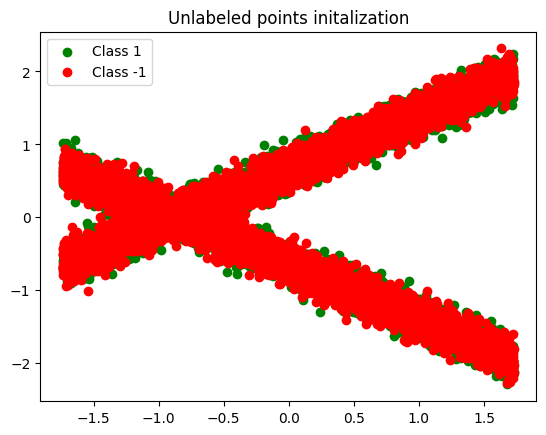

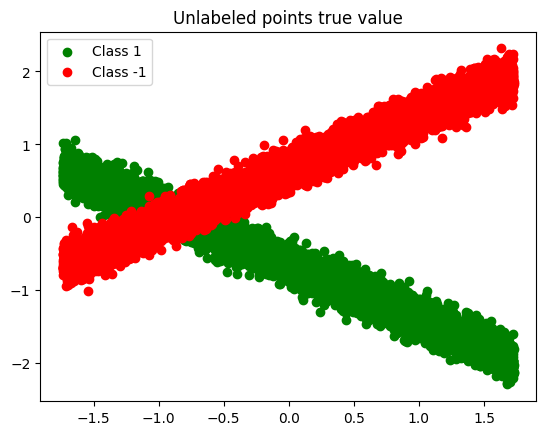

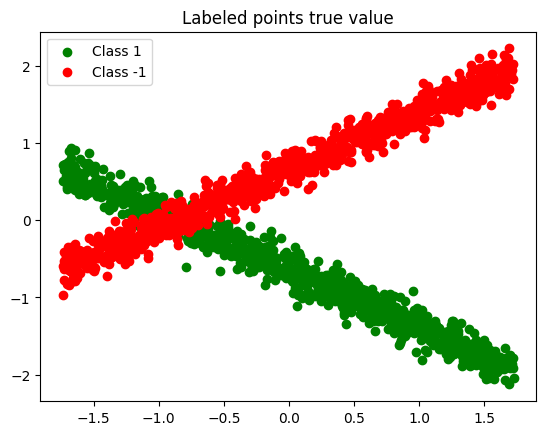

CPU times: total: 2.06 s
Wall time: 4.39 s


In [6]:
%%time
plt.figure(dpi=PLOT_DPI)
plt.title("Unlabeled points initalization")
plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_initial == 1]], [p[1] for p in x_unlabeled[y_unlabeled_initial == 1]], color='green', label='Class 1')
plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_initial== -1]], [p[1] for p in x_unlabeled[y_unlabeled_initial == -1]], color='red', label='Class -1')
plt.legend()
plt.show()

plt.figure(dpi=PLOT_DPI)
plt.title("Unlabeled points true value")
plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == 1]], [p[1] for p in x_unlabeled[y_unlabeled_target == 1]], color='green', label='Class 1')
plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == -1]], [p[1] for p in x_unlabeled[y_unlabeled_target == -1]], color='red', label='Class -1')
plt.legend()
plt.show()


plt.figure(dpi=PLOT_DPI)
plt.title("Labeled points true value")
plt.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]], color='green', label='Class 1')
plt.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]], color='red', label='Class -1')
plt.legend()
plt.show()

## FORMALIZATION: 
#### Loss function, Gradient, Weights, Hessian, Accuracy

## 2. Choosing a proper similarity measure to define the weights

CPU times: total: 46.9 ms
Wall time: 36.2 ms


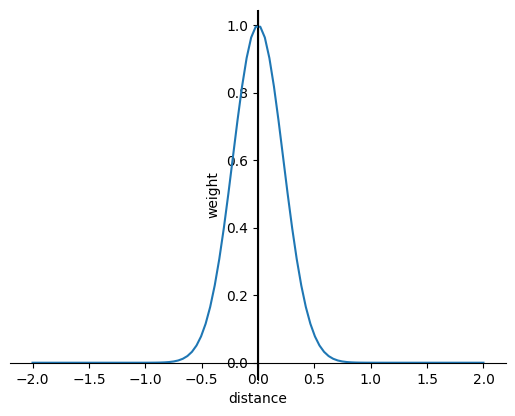

In [7]:
%%time
# WEIGHTS
def weight_function(dist):
    return math.e**(-10* dist**2)

# PLOT
X = np.linspace(-2, 2, 100)
plt.figure(dpi=PLOT_DPI)
ax = plt.gca()
ax.legend_= None
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.set_ylabel('weight')
ax.set_xlabel('distance')
ax.axvline(x=0, color='k')
ax.plot(X, [weight_function(d) for d in X], label="asd")

In [8]:
%%time
# W
def weights_labeled_unlabeled_iterative():
    labeled_unlabeled = np.zeros((len(x_labeled), len(x_unlabeled))).astype('float64')
    for i in range(len(x_unlabeled)):
        if i % (len(x_unlabeled) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(x_unlabeled)*100):02}%")
        for j in range(len(x_labeled)):
            labeled_unlabeled[j][i] = weight_function(np.linalg.norm(x_unlabeled[i] - x_labeled[j]))
    return labeled_unlabeled

def weights_labeled_unlabeled():
    labeled_unlabeled = euclidean_distances(x_labeled, x_unlabeled) / x_labeled.shape[1]
    return weight_function(labeled_unlabeled)
print("Calculating weights between labeled points and unlabeled points")
W = weights_labeled_unlabeled()
print("Done")



Calculating weights between labeled points and unlabeled points
Done
CPU times: total: 4.73 s
Wall time: 12.2 s


In [9]:
# W_BAR
def weights_unlabeled_unlabeled_iterative():
    unlabeled_unlabeled = np.zeros((len(x_unlabeled), len(x_unlabeled))).astype('float64')
    for i in range(len(x_unlabeled)):
        if i % (len(x_unlabeled) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(x_unlabeled)*100):02}%")
        for j in range(len(x_unlabeled)):
            unlabeled_unlabeled[j][i] = weight_function(np.linalg.norm(x_unlabeled[i] - x_unlabeled[j]))
    return unlabeled_unlabeled
def weights_unlabeled_unlabeled():
    unlabeled_unlabeled = euclidean_distances(x_unlabeled, x_unlabeled) / x_unlabeled.shape[1]
    return weight_function(unlabeled_unlabeled)

print("Calculating weights between unlabeled points and unlabeled points")
W_bar = weights_unlabeled_unlabeled()
print("Done")

Calculating weights between unlabeled points and unlabeled points
Done


## 3. We write down the problem

In [27]:
%%time
# LOSS FUNCTION
def loss_iterative(labeled, unlabeled):
    global W, W_bar
    tot1 = tot2 = 0.0
    for i in range(len(labeled)):
        for j in range(len(unlabeled)):
            tot1 += W[i][j] * (unlabeled[j] - labeled[i])**2
    for i in range(len(unlabeled)):
        for j in range(len(unlabeled)):
            tot2 += W_bar[i][j] * (unlabeled[i] - unlabeled[j])**2
    return tot1 + tot2/2

def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * W.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * W_bar.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
%%time
# ACCURACY FUNCTION
def accuracy(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            y_unlabeled_target
        )
    ) / len(y_unlabeled_target)
max_loss = np.sum(W) * 4 + np.sum(W_bar) * 2
print(f"Max loss: {max_loss}")

Max loss: 115506871.3727652
CPU times: total: 2.22 s
Wall time: 5.14 s


In [12]:
%%time
# HESSIAN AND LIPSCHITZ CONSTANT
def hessian_matrix(W_bar, W):
    mat = np.copy(-W_bar)
    for i in range(len(y_unlabeled_target)):
        if i % (len(y_unlabeled_target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(y_unlabeled_target)*100):02}% ... ", end="")
        mat[i][i] = 2 * np.sum(W[:,i]) + np.sum(W_bar[:,i]) - W_bar[i][i]
    print()
    return mat

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
def estimate_degree_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Calculating the Hessian matrix")
    hessian = hessian_matrix(W_bar, W)
    print("Calculating sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled_target))
print("Done")


Calculating the Hessian matrix
00% ... 10% ... 20% ... 30% ... 40% ... 50% ... 60% ... 70% ... 80% ... 90% ... 
Calculating sigma (strongly convex)
Sigma: 483.286799292044,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 5412.661858627785
Estimating Lipschitz constant for each single variable
Done
CPU times: total: 1h 10min 48s
Wall time: 1h 7min 9s


#### Free tips: GRADIENT

In [13]:
%%time
# GRADIENT
def gradient(W_bar, W, y_lab, y_unlab_pred):
    """
    Computes the gradient of the loss function with respect to y_unlab.

    Args:
        W_bar (np.ndarray): Weight matrix for unlabeled data (n_unlabeled_samples, n_unlabeled_samples).
        W (np.ndarray): Weight matrix between labeled and unlabeled data (n_labeled_samples, n_unlabeled_samples).
        y_lab (np.ndarray): Labels for the labeled data (n_labeled_samples,).
        y_unlab_pred (np.ndarray): Current predictions for the unlabeled data (n_unlabeled_samples,).

    Returns:
        np.ndarray: The computed gradient vector.
    """
    # Gradient with respect to y_unlab
    grad_first_term = -2 * np.sum(W * (y_lab[:, np.newaxis] - y_unlab_pred[np.newaxis, :]), axis=0)
    grad_second_term = -np.sum(W_bar * (y_unlab_pred[:, np.newaxis] - y_unlab_pred[np.newaxis, :]), axis=1)

    return grad_first_term + grad_second_term

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
# GRADIENT
# We rewrite the gradient in a format that allows us to avoid to redo those calculation every time
print("Calculating coefficients of the gradient")
sum_row_label_unlabel = np.sum(W, axis=0).reshape((-1,1))
sum_row_unlabel_unlabel = np.sum(W_bar, axis=0).reshape((-1,1))
grad_first_coeff_vec = (2 * sum_row_label_unlabel + sum_row_unlabel_unlabel)
grad_second_coeff_vec = 2 * np.multiply(
    y_labeled.reshape((-1,1)),
    W
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


## 4. We solve the problem with the algorithms

### Gradient Descent

In [29]:
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_coeff = np.multiply(
        unlabeled,
        W_bar
    ).sum(0).reshape((-1,1))
    return (grad_first_coeff_vec * unlabeled - grad_second_coeff_vec - third_coeff).reshape((-1,))

In [30]:
y_unlabeled_gd = np.copy(y_unlabeled_initial)

In [ ]:
%%time
t_gd= [0]
accuracies_gd = [accuracy(y_unlabeled_gd)]
losses_gd = [loss(y_labeled, y_unlabeled_gd)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    accuracies_gd.append(accuracy(y_unlabeled_gd))
    losses_gd.append(loss(y_labeled, y_unlabeled_gd))
    t_gd.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(y_labeled, y_unlabeled_gd)}
""")

00% - iter 0 / 60 - final accuracy 56.39% - loss 6782902.68
10% - iter 6 / 60

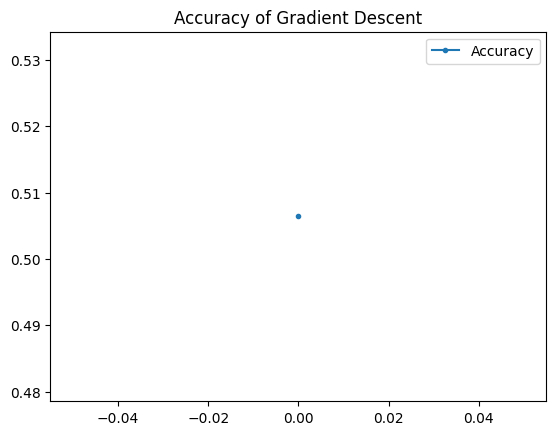

In [18]:
# Plot the accuracy for Gradient Descent
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of Gradient Descent")
plt.plot(t_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"])

### Block Coordinate Gradient Method with Gauss-Southwell

In [19]:
def new_gradient(previous_grad, Li, index):
    global w_unlabeled_unlabeled, grad_first_coeff_vec
    step = 1/Li[index] * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += w_unlabeled_unlabeled[index] * step
    new_grad[index] -= grad_first_coeff_vec[index] * step
    return step, new_grad

In [20]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")

In [ ]:
%%time
t_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd_gs)]

max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = new_gradient(previous_grad_gs, Li, index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(y_unlabeled_target) == 0:
        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd_gs))
        t_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_gs)}
""")

TypeError: loss() missing 2 required positional arguments: 'y_lab' and 'y_unlab_pred'

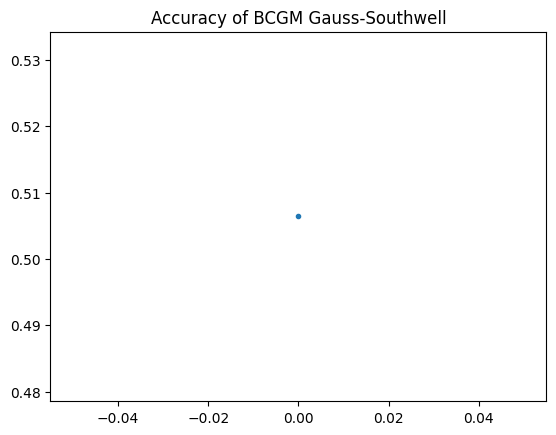

In [22]:
# Plot the accuracy for BCGM Gauss-Southwell
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of BCGM Gauss-Southwell")
plt.plot(t_bcgd_gs, accuracies_bcgd_gs, marker='.')

### Coordinate Minimization

In [23]:
y_unlabeled_cm = np.copy(y_unlabeled_initial)

In [ ]:
%%time
# Initialize lists to store metrics for Coordinate Minimization
t_cm = [0]
# Ensure y_unlabeled_cm is initialized (from cell 33)
accuracies_cm = [accuracy(y_unlabeled_cm)]
# Assuming loss function takes (y_labeled, y_unlabeled_pred) based on usage in cells 25, 30
# If loss function strictly requires W, W_bar as args per cell 15, this would be:
# losses_cm = [loss(W_bar, W, y_labeled, y_unlabeled_cm)]
losses_cm = [loss(y_labeled, y_unlabeled_cm)]


init_time = time.time() * 1000

print("Starting Coordinate Minimization...")
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

    # Iterate over each coordinate
    for j in range(len(y_unlabeled_cm)):
        # Optimal value for y_unlabeled_cm[j] is derived by setting partial derivative of loss w.r.t. y_unlabeled_cm[j] to 0
        # y_j_new = ( b_j + sum_{k!=j} W_bar_jk * y_k_old ) / ( D_jj - W_bar_jj )
        # where b_j = grad_second_coeff_vec[j][0]
        # D_jj - W_bar_jj = grad_first_coeff_vec[j][0] - W_bar[j,j]
        # sum_{k!=j} W_bar_jk * y_k_old = (np.dot(W_bar[j, :], y_unlabeled_cm) - W_bar[j,j] * y_unlabeled_cm[j])
        
        numerator = grad_second_coeff_vec[j][0] + (np.dot(W_bar[j, :], y_unlabeled_cm) - W_bar[j,j] * y_unlabeled_cm[j])
        denominator = grad_first_coeff_vec[j][0] - W_bar[j,j]

        if denominator != 0:
            y_unlabeled_cm[j] = numerator / denominator
        # Else: if denominator is 0, y_unlabeled_cm[j] remains unchanged (isolated point)

    # After one full pass over all coordinates
    current_accuracy = accuracy(y_unlabeled_cm)
    accuracies_cm.append(current_accuracy)
    # Consistent loss call
    current_loss = loss(y_labeled, y_unlabeled_cm)
    losses_cm.append(current_loss)
    t_cm.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - accuracy {current_accuracy*100:05.2f}% - loss {current_loss:05.2f}")

# Calculate final gradient norm for comparison (using gradient function from cell 23)
final_grad_cm = gradient(y_unlabeled_cm)
final_accuracy_cm = accuracies_cm[-1]
final_loss_cm = losses_cm[-1]

print(f"""
Coordinate Minimization Finished.
Final accuracy: {round(final_accuracy_cm * 100, 2)}%
Norm gradient: {np.linalg.norm(final_grad_cm)}
Loss: {final_loss_cm}
Total iterations (epochs): {NUM_ITERS}
""")

TypeError: loss() missing 2 required positional arguments: 'y_lab' and 'y_unlab_pred'

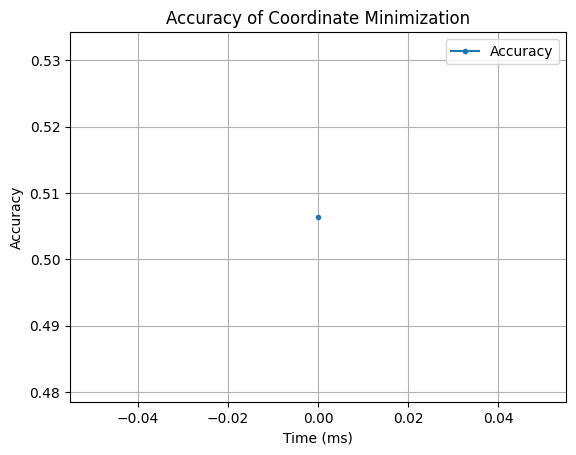

In [25]:
# Plot the accuracy for Coordinate Minimization
plt.figure(dpi=PLOT_DPI if 'PLOT_DPI' in locals() else 100) # Use PLOT_DPI if available
plt.title("Accuracy of Coordinate Minimization")
plt.plot(t_cm, accuracies_cm, marker='.')
plt.xlabel("Time (ms)")
plt.ylabel("Accuracy")
plt.legend(["Accuracy"])
plt.grid(True)
plt.show()

## Algorithms Comparison

In [26]:
min_acc = np.min(
    np.concatenate(
        (accuracies_bcgd_gs, accuracies_gd, accuracies_cm)
    )
)
max_acc = np.max(
    np.concatenate(
        (accuracies_bcgd_gs, accuracies_gd, accuracies_cm)
    )
)
min_y_plot = max(min_acc - .1 * (1 - min_acc), 0.5)
max_y_plot = max_acc + (.1 * (1 - max_acc))